<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Feature Selection (FS) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1; text-align: center;">
    Required Imports
</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1; ">
    Package Descriptions
</h3>
<ul style="font-family: 'Arial', sans-serif; line-height: 1.8;">
    <li><strong>pandas</strong>: For data manipulation and analysis, allowing easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: For creating basic plots and data visualizations.</li>
    <li><strong>seaborn</strong>: For creating more attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand the dataset's quality.</li>
</ul>


In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
from scipy import stats # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, Ridge, ElasticNetCV, ElasticNet # type: ignore

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

import sys
import os

sys.path.append(os.path.abspath("../utils"))
from models import monitor_model_rfe, select_best_features_and_save, analyze_feature_consensus


import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section loads the dataset into the environment for further analysis and processing. By utilizing <code>pandas</code>, we can efficiently read and manipulate data, allowing for seamless integration in the analysis pipeline.
</p>


In [2]:
path = "../data/"

X_train = pd.read_csv(path + "X_train_post_PTD.csv")
X_train_ar = pd.read_csv(path + "X_train_ar_post_PTD.csv")
X_train_wcb = pd.read_csv(path + "X_train_wcb_post_PTD.csv")

X_val = pd.read_csv(path + "X_val_post_PTD.csv")
X_val_ar = pd.read_csv(path + "X_val_ar_post_PTD.csv")
X_val_wcb = pd.read_csv(path + "X_val_wcb_post_PTD.csv")

y_train = pd.read_csv(path + "y_train_post_PTD.csv")
y_train_ar = pd.read_csv(path + "y_train_ar_post_PTD.csv")
y_train_wcb = pd.read_csv(path + "y_train_wcb_post_PTD.csv")

y_val = pd.read_csv(path + 'y_val_post_PTD.csv')
y_val_ar = pd.read_csv(path + 'y_val_ar_post_PTD.csv')
y_val_wcb = pd.read_csv(path + 'y_val_wcb_post_PTD.csv')

data_test = pd.read_csv(path + "data_test_post_PTD.csv")
data_test_ar = pd.read_csv(path + "data_test_ar_post_PTD.csv")
data_test_wcb = pd.read_csv(path + "data_test_wcb_post_PTD.csv")

In [3]:
X_train_sampled, _ = train_test_split(X_train, train_size=0.05, stratify=y_train["Claim Injury Type"], random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this section, we do data scaling is applied to normalize features, ensuring that all variables contribute equally to the model without being impacted by differing scales. This step is crucial for algorithms sensitive to feature magnitudes, such as regression and distance-based models.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data scaling is an essential preprocessing step to standardize the range of independent variables. By scaling features, we ensure that all variables contribute equally to model training, avoiding bias toward features with larger scales. Scaling is particularly important for algorithms sensitive to feature magnitudes, such as gradient-based methods and distance-based models.
</p>


In [4]:
# Initialize the scaler
scaler = StandardScaler()

In [5]:
# Fit the scaler on the training data (this step calculates the mean and std dev of X_train only)
scaler.fit(X_train_sampled)

StandardScaler()

In [6]:
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [7]:
# Transform the validation data using the same scaler (without fitting)
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [8]:
# If you also want to scale the test data in the same manner:
X_test_scaled = scaler.transform(data_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=data_test.columns)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Feature Selection Results
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section presents the results of the feature selection process, highlighting the most relevant variables for predicting the target outcome. By reducing dimensionality, we aim to enhance model performance, decrease overfitting, and improve interpretability. Selected features are retained for model training, while less informative variables are removed.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Filter Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Filter methods are a feature selection approach that assesses each feature's relevance based on statistical measures. These methods are computationally efficient and independent of the machine learning model, making them ideal for initial feature selection. Common techniques include correlation scores, chi-square tests, and mutual information, which help identify the most informative variables for model training.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Univariate Variables
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Univariate analysis focuses on examining each variable individually to understand its distribution, central tendency, and spread. This approach is useful for identifying basic patterns and outliers within single features, and it provides insights into which variables may have a significant impact on the target outcome. Univariate analysis is often the first step in exploratory data analysis and feature selection.
</p>


In [9]:
# Identify columns with zero variance in the scaled X_train data
zero_variance_columns = X_train_scaled.var() == 0

In [10]:
# List the column names with zero variance
zero_variance_columns_list = X_train_scaled.columns[zero_variance_columns].tolist()

In [11]:
# Print columns with zero variance
print("Colunas com variância igual a zero:", zero_variance_columns_list)

Colunas com variância igual a zero: ['missing_Assembly Date', 'missing_Medical_Fee_Region', 'missing_Number_of_Dependents', 'Alternative Dispute Resolution_U', 'Dispute_and_Rep_U_N', 'Dispute_and_Rep_U_Y', 'First Hearing Date_IsWeekend']


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Correlation Indices
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Correlation indices measure the strength and direction of relationships between variables, helping to identify pairs of features that may have linear dependencies. High correlation values (positive or negative) indicate a strong relationship, which can guide feature selection by revealing redundant variables. Analyzing these indices aids in understanding interactions within the dataset and optimizing model performance.
</p>


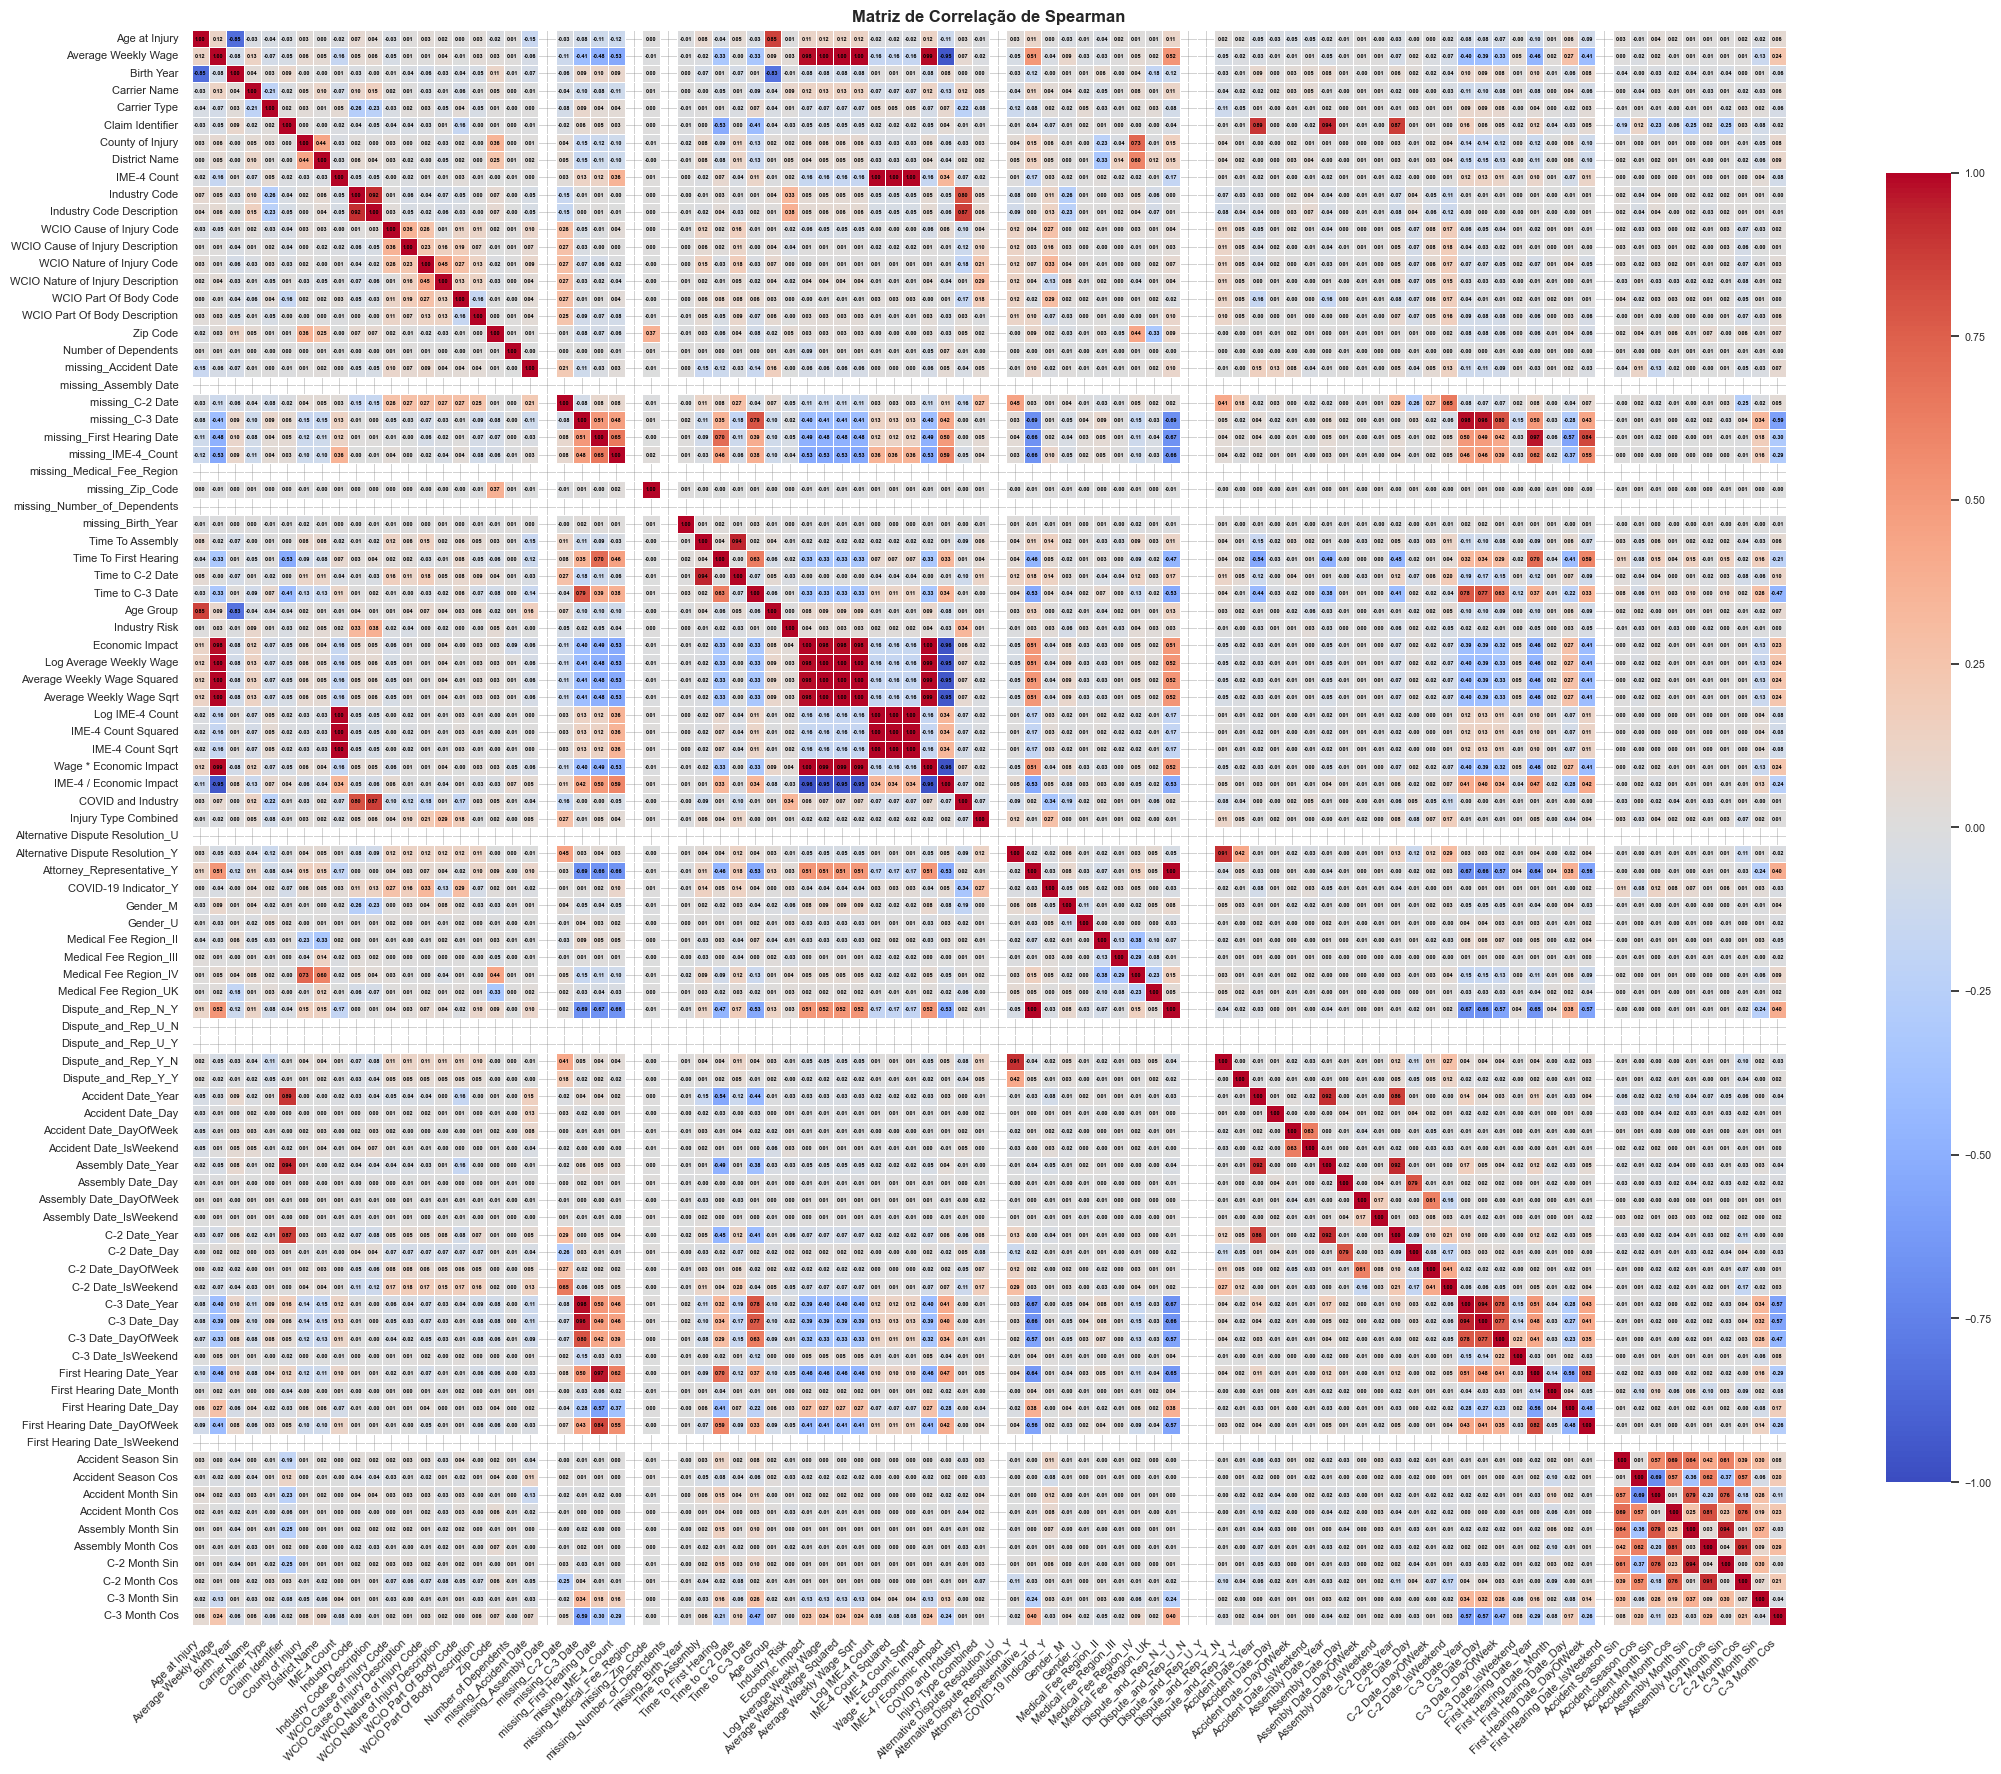

In [12]:
corr_spearman = X_train_scaled.corr(method='spearman')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(corr_spearman,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 4, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Spearman', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

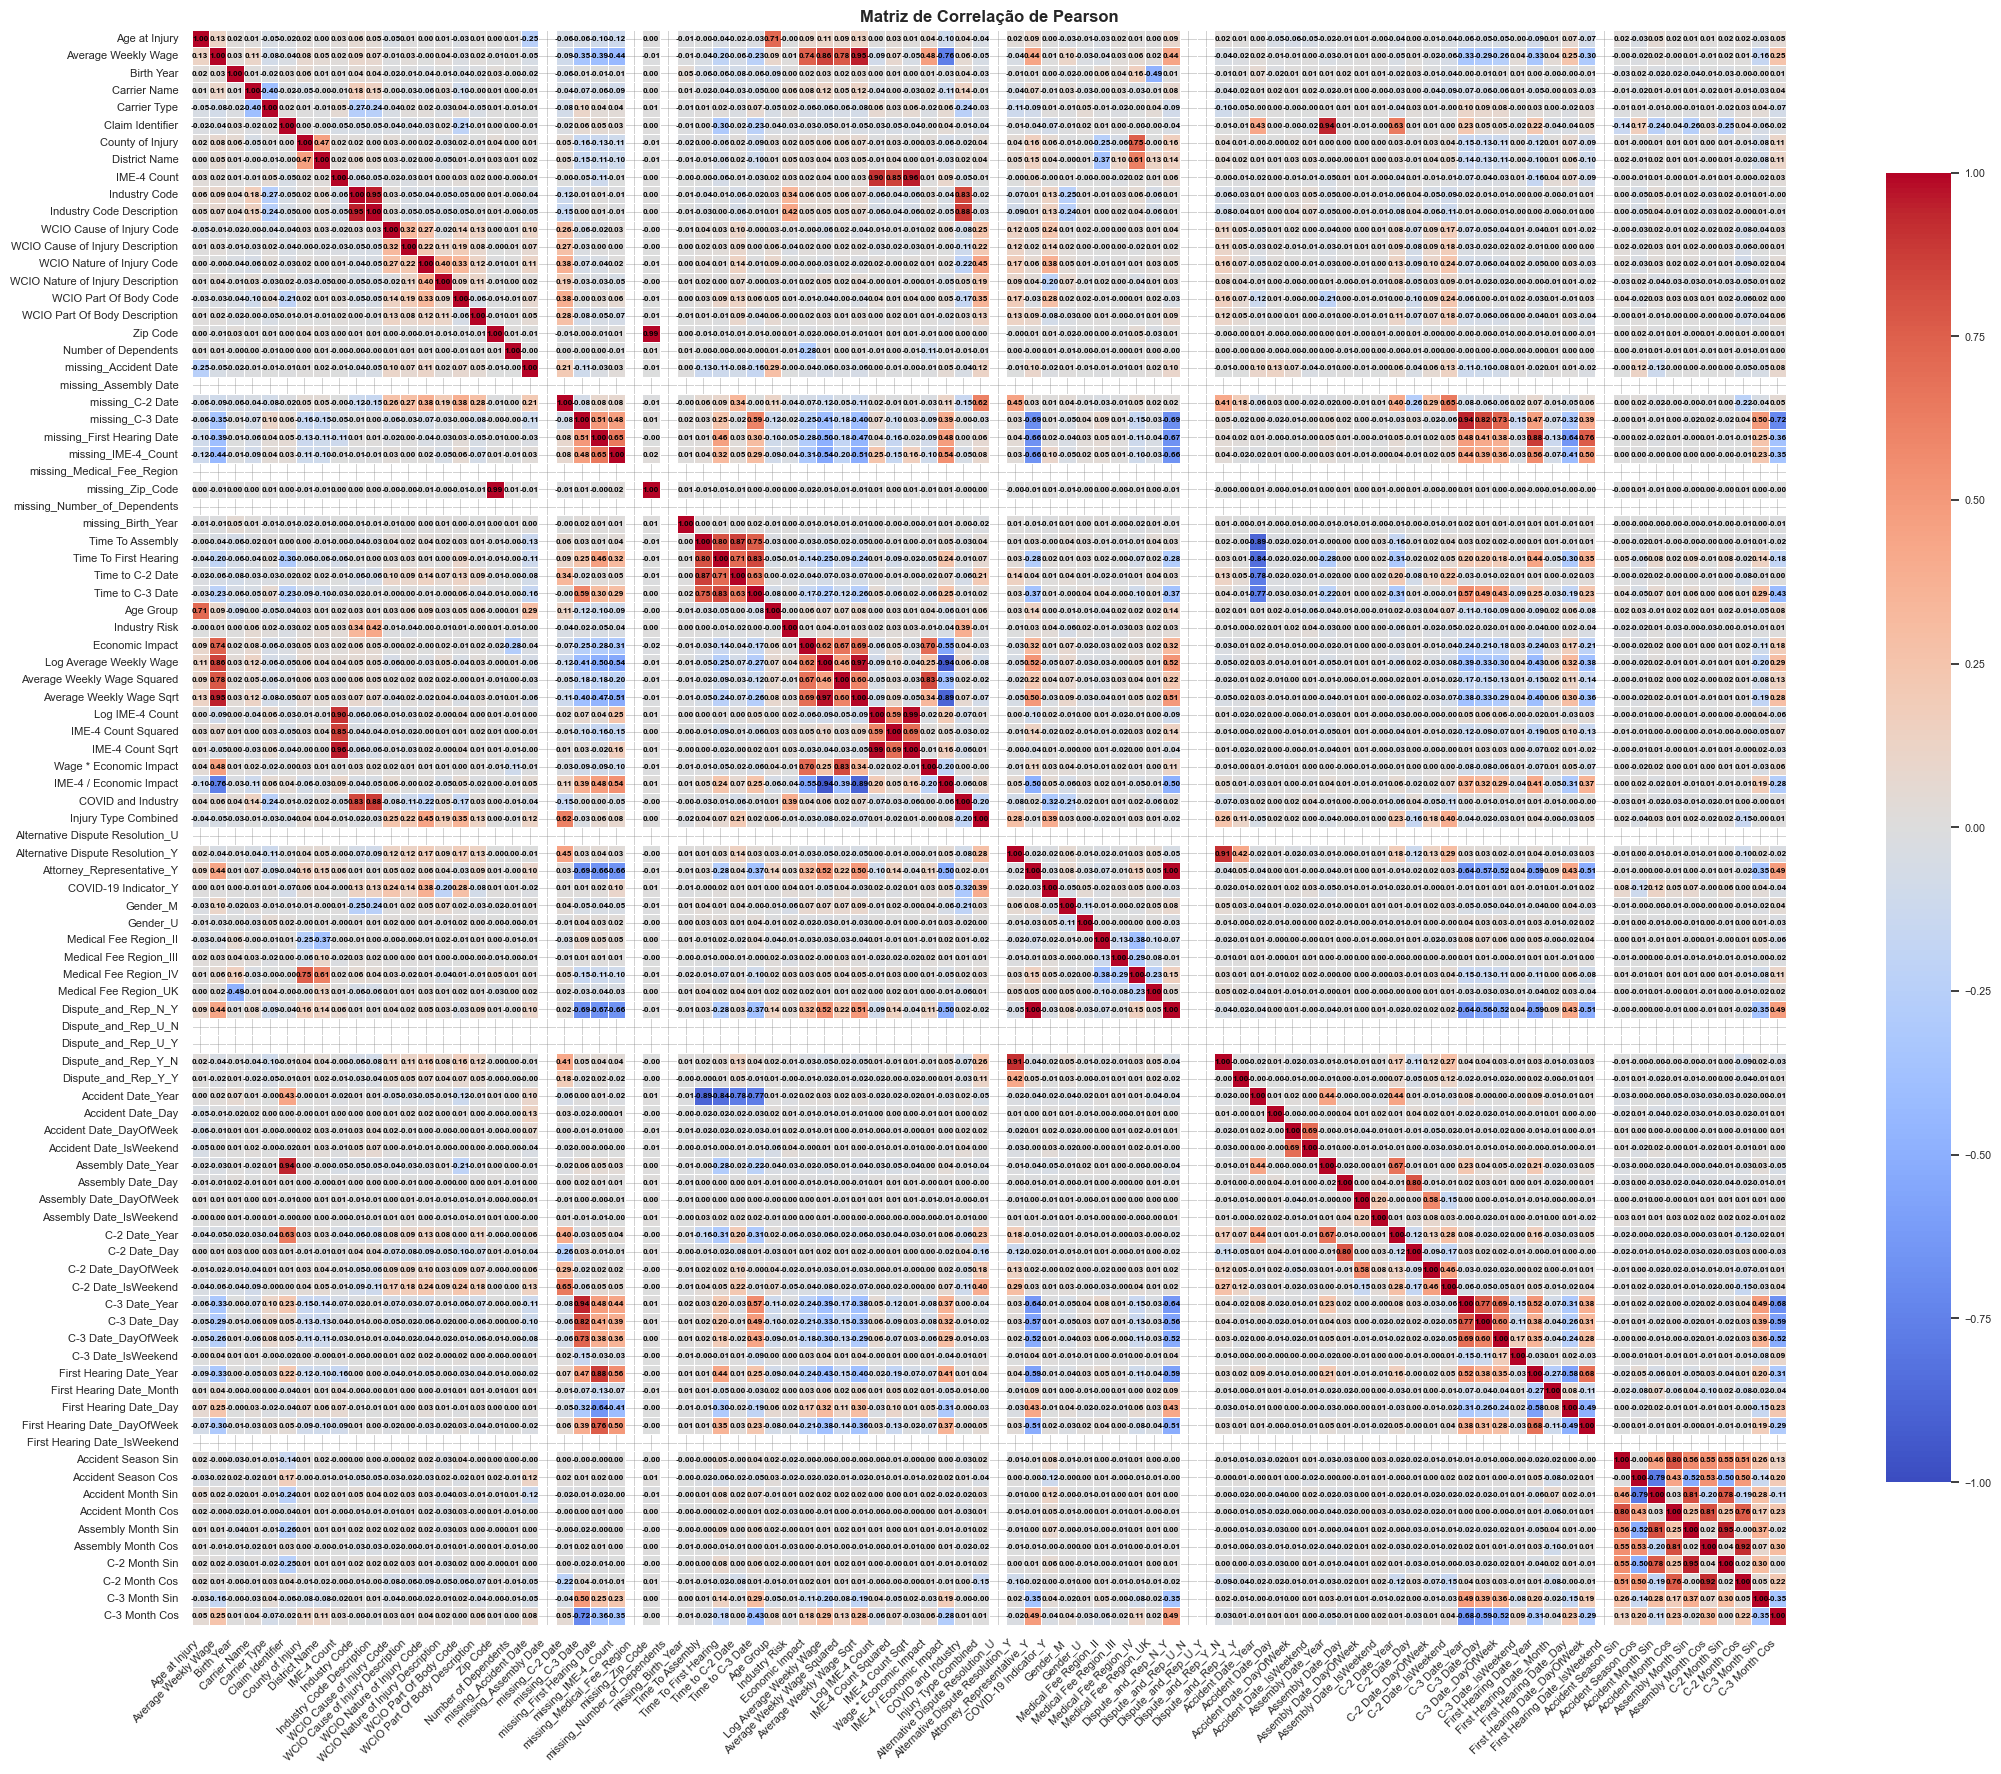

In [13]:
corr_pearson = X_train_scaled.corr(method='pearson')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(corr_pearson,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 6, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Pearson', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

<h1 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Wrapper Methods for Feature Selection (RFE -> Recursive Feature Elimination)
</h1>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Decision Tree Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Decision Tree Classifier</strong> was chosen as the base estimator for <strong>Recursive Feature Elimination (RFE)</strong> due to its ability to evaluate and rank feature importance effectively. This approach aligns well with the objectives of the project, which involve identifying the most relevant predictors for the target variable, <strong>Claim Injury Type</strong>.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for the Choice
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Feature Importance:</strong> Decision Trees inherently compute feature importance scores based on information gain or Gini impurity. These scores allow RFE to iteratively eliminate less significant features, ensuring that only the most informative variables are retained.</li>
    <li><strong>Flexibility with Data:</strong> Unlike other methods, Decision Trees can handle both <em>numerical</em> and <em>categorical features</em> without requiring extensive preprocessing, making them highly suitable for the dataset at hand.</li>
    <li><strong>Non-Linearity:</strong> The algorithm effectively captures <em>non-linear relationships</em> between features and the target variable, which is critical given the complexity of real-world datasets.</li>
    <li><strong>Model Simplification:</strong> By reducing feature redundancy and dimensionality, the model becomes more interpretable and computationally efficient while improving generalization performance.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Integration into the Workflow
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this project, the RFE process was implemented as follows:
</p>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li>Initialize a <strong>Decision Tree Classifier</strong> as the estimator.</li>
    <li>Run the <strong>RFE algorithm</strong> to iteratively evaluate feature importance and remove less relevant predictors.</li>
    <li>Retain the most informative subset of features, ensuring improved performance during model training.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Expected Outcomes
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Improved Model Performance:</strong> By eliminating irrelevant features, the model is expected to achieve higher accuracy and reduced overfitting.</li>
    <li><strong>Enhanced Interpretability:</strong> Focusing on the most relevant features provides better insights into their relationship with the <strong>Claim Injury Type</strong>.</li>
    <li><strong>Reduced Complexity:</strong> Fewer features lead to a more efficient and less computationally expensive model.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Using the <strong>Decision Tree Classifier</strong> as the base model for <strong>RFE</strong> is a well-justified choice. Its ability to rank features, handle complex relationships, and work with mixed data types makes it highly suitable for feature selection in this project. By integrating this approach, the model’s performance, efficiency, and interpretability are significantly enhanced, ensuring the project's goals are achieved effectively.
</p>

In [14]:
dtc_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=100,
    min_samples_leaf=5,
    random_state=42,
)


In [15]:
monitor_model_rfe(dtc_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5),
                  nof=None, log_file="rfe_dt.txt", output_csv="DecisionTree.csv")


Feature Selection Progress:  72%|███████▏  | 13/18 [03:56<01:30, 18.17s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_dt.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\DecisionTree.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Random Forest Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Random Forest Classifier</strong> is a powerful ensemble learning method that combines multiple decision trees to improve classification accuracy and reduce overfitting. In the context of this project, Random Forest provides robust and reliable <strong>feature importance scores</strong>, which are critical for <strong>Recursive Feature Elimination (RFE)</strong> and overall feature selection.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for Using Random Forest
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Feature Importance Metrics:</strong> Random Forest computes importance scores by analyzing the frequency and quality of splits for each feature across multiple decision trees.</li>
    <li><strong>Handling High-Dimensional Data:</strong> Its ensemble approach is highly effective for datasets with many features, identifying the most relevant ones efficiently.</li>
    <li><strong>Robust to Overfitting:</strong> By averaging results from multiple decision trees, Random Forest reduces overfitting, improving generalization.</li>
    <li><strong>Non-Linearity:</strong> Like decision trees, Random Forest captures <em>non-linear relationships</em> between features and the target variable.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    How Random Forest Works for RFE
</h3>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Model Initialization:</strong> Train the <strong>Random Forest Classifier</strong> on the dataset with all features.</li>
    <li><strong>Feature Importance Ranking:</strong> Extract feature importance scores derived from the contribution of each feature to splits across the trees.</li>
    <li><strong>Recursive Elimination:</strong> Use RFE to iteratively remove the least important features based on their scores and retrain the model.</li>
    <li><strong>Performance Evaluation:</strong> Assess model performance after each iteration to determine the optimal subset of features.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Benefits for the Project
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Improved Accuracy:</strong> Random Forest leverages the power of ensembles to ensure high accuracy, even with complex datasets.</li>
    <li><strong>Effective Feature Selection:</strong> Reliable importance scores ensure the most informative features are retained for downstream modeling.</li>
    <li><strong>Reduced Overfitting:</strong> The ensemble nature minimizes overfitting risks when compared to single decision trees.</li>
    <li><strong>Interpretability:</strong> Feature importance scores offer insights into the variables contributing most to predicting the <strong>Claim Injury Type</strong>.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Random Forest Classifier</strong> is an ideal choice for <strong>Recursive Feature Elimination (RFE)</strong> in this project. Its ability to compute reliable feature importance scores, handle high-dimensional data, and reduce overfitting ensures optimal feature selection. By integrating Random Forest into the workflow, the model achieves better accuracy, interpretability, and overall robustness for predicting the <strong>Claim Injury Type</strong>.
</p>

In [16]:
rfc_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

In [17]:
monitor_model_rfe(rfc_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), 
                  nof=None, log_file="rfe_rtc.txt", output_csv="RandomForestClassifier.csv")


Feature Selection Progress:  67%|██████▋   | 12/18 [02:08<01:04, 10.68s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_rtc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\RandomForestClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Extra Trees Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Extra Trees Classifier</strong> is an ensemble learning method that builds a forest of randomized decision trees to improve classification accuracy and generalization. Compared to the <strong>Random Forest Classifier</strong>, Extra Trees introduces additional randomness during tree construction, which enhances model diversity and reduces overfitting.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for Using Extra Trees
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Faster Training:</strong> Extra Trees builds trees with random splits instead of searching for the best split, resulting in faster training times.</li>
    <li><strong>Feature Importance:</strong> It computes robust feature importance scores, which are valuable for identifying the most relevant predictors in high-dimensional datasets.</li>
    <li><strong>Handling Complexity:</strong> The additional randomness in Extra Trees enhances its ability to generalize across complex datasets while reducing overfitting.</li>
    <li><strong>Non-Linearity:</strong> Similar to other tree-based methods, Extra Trees can model non-linear relationships effectively, making it highly versatile for feature selection.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    How Extra Trees Works for RFE
</h3>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Model Initialization:</strong> Train an <strong>Extra Trees Classifier</strong> on the dataset using all available features.</li>
    <li><strong>Feature Importance Computation:</strong> Extract feature importance scores derived from the frequency and quality of splits in each randomized tree.</li>
    <li><strong>Recursive Elimination:</strong> Use <strong>RFE</strong> to iteratively remove the least important features based on their scores.</li>
    <li><strong>Performance Evaluation:</strong> Evaluate the model at each step to identify the optimal subset of features that improves generalization and accuracy.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Benefits for the Project
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Efficiency:</strong> Faster training time makes Extra Trees ideal for large, high-dimensional datasets.</li>
    <li><strong>Improved Generalization:</strong> Random splits increase model diversity, reducing the risk of overfitting.</li>
    <li><strong>Robust Feature Selection:</strong> The importance scores provide reliable insights into which features contribute most to predicting the <strong>Claim Injury Type</strong>.</li>
    <li><strong>Versatility:</strong> It handles both continuous and categorical features seamlessly without the need for extensive preprocessing.</li>
</ul>
<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Extra Trees Classifier</strong> is a highly efficient and reliable method for <strong>Recursive Feature Elimination (RFE)</strong> in this project. Its ability to compute robust feature importance scores, handle non-linear relationships, and train faster on large datasets makes it an excellent choice for feature selection. By leveraging Extra Trees, the model's performance, generalizability, and efficiency are significantly improved when predicting the <strong>Claim Injury Type</strong>.
</p>


In [18]:
etc_model = ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=-1)

In [19]:
monitor_model_rfe(etc_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), 
                  nof=None, log_file="rfe_etc.txt", output_csv="ExtraTreesClassifier.csv")


Feature Selection Progress: 100%|██████████| 18/18 [01:43<00:00,  5.73s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_etc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\ExtraTreesClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Gradient Boosting Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Gradient Boosting Classifier</strong> is a powerful ensemble learning method that builds models sequentially by combining multiple weak learners, typically decision trees. It optimizes the model’s performance by correcting the errors of previous iterations, achieving high accuracy and robust classification performance.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for Using Gradient Boosting
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>High Accuracy:</strong> Gradient Boosting is known for its superior predictive performance, especially on complex datasets.</li>
    <li><strong>Feature Importance:</strong> Like other tree-based models, Gradient Boosting computes feature importance scores, which can be used to rank and select the most relevant features.</li>
    <li><strong>Error Optimization:</strong> By minimizing a loss function (e.g., log-loss for classification), each subsequent tree focuses on correcting errors from previous iterations.</li>
    <li><strong>Fine-Tuning Flexibility:</strong> It allows for hyperparameter tuning (e.g., learning rate, tree depth) to balance bias and variance effectively.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    How Gradient Boosting Works for RFE
</h3>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Model Initialization:</strong> Train a <strong>Gradient Boosting Classifier</strong> on the dataset with all available features.</li>
    <li><strong>Feature Importance Computation:</strong> Extract importance scores for each feature based on their contribution to the model.</li>
    <li><strong>Recursive Elimination:</strong> Use <strong>RFE</strong> to iteratively eliminate the least important features based on these scores.</li>
    <li><strong>Performance Evaluation:</strong> Assess the model's performance (e.g., using cross-validation) to determine the optimal subset of features.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Benefits for the Project
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Improved Accuracy:</strong> Gradient Boosting is well-suited for achieving high classification accuracy in complex datasets.</li>
    <li><strong>Effective Feature Selection:</strong> Its importance scores help identify and retain the most relevant predictors for <strong>Claim Injury Type</strong>.</li>
    <li><strong>Model Customization:</strong> The model allows fine-tuning of hyperparameters, enabling better control over bias-variance tradeoffs.</li>
    <li><strong>Generalization:</strong> By sequentially optimizing errors, Gradient Boosting improves model robustness and generalizability.</li>
</ul>
<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Gradient Boosting Classifier</strong> is a highly effective model for <strong>Recursive Feature Elimination (RFE)</strong> due to its ability to compute reliable feature importance scores and sequentially optimize errors. By leveraging Gradient Boosting, the model achieves higher accuracy, robust feature selection, and improved generalization, ensuring optimal performance in predicting the <strong>Claim Injury Type</strong>.
</p>


In [20]:
gbc_model = GradientBoostingClassifier(n_estimators=1, max_depth=3, random_state=42)

In [21]:
monitor_model_rfe(gbc_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), 
                  nof=None, log_file="rfe_gbc.txt", output_csv="GradientBoostingClassifier.csv")


Feature Selection Progress:  83%|████████▎ | 15/18 [12:54<02:34, 51.64s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_gbc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\GradientBoostingClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     XGBoost Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>XGBoost Classifier</strong> (Extreme Gradient Boosting) is a highly efficient and scalable ensemble learning method that sequentially builds decision trees to improve classification accuracy. It provides robust <strong>feature importance metrics</strong>, derived from feature contributions to split quality, making it a powerful tool for advanced feature selection.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for Using XGBoost
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Efficiency:</strong> XGBoost is optimized for large datasets, handling high-dimensional data effectively.</li>
    <li><strong>Feature Importance:</strong> It tracks the gain from splits involving each feature, making it ideal for identifying and ranking feature relevance.</li>
    <li><strong>Regularization:</strong> Built-in L1 and L2 regularization terms prevent overfitting, ensuring reliable feature selection.</li>
    <li><strong>Customizable Loss Functions:</strong> XGBoost supports various loss functions, enabling fine-tuning for specific classification tasks.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    How XGBoost Works for RFE
</h3>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Model Initialization:</strong> Train an <strong>XGBoost Classifier</strong> on the dataset with all available features.</li>
    <li><strong>Feature Importance Computation:</strong> Extract importance scores (e.g., gain, weight, cover) for each feature based on their contribution to tree splits.</li>
    <li><strong>Recursive Elimination:</strong> Use <strong>RFE</strong> to iteratively remove the least important features based on these scores.</li>
    <li><strong>Performance Evaluation:</strong> Assess the model’s performance (e.g., using cross-validation) at each step to determine the optimal subset of features.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Benefits for the Project
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Improved Accuracy:</strong> XGBoost achieves high predictive accuracy by leveraging advanced optimization techniques.</li>
    <li><strong>Effective Feature Selection:</strong> Importance metrics provide insights into feature relevance, allowing the elimination of redundant or irrelevant features.</li>
    <li><strong>Robustness:</strong> Regularization ensures the model is not overly sensitive to noise, improving generalization.</li>
    <li><strong>Scalability:</strong> Its parallel processing capabilities make it suitable for large datasets.</li>
</ul>
<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>XGBoost Classifier</strong> is an exceptional tool for <strong>Recursive Feature Elimination (RFE)</strong>, combining scalability, efficiency, and robust feature importance metrics. By integrating XGBoost into the workflow, the project benefits from improved accuracy, efficient feature selection, and enhanced model generalization, ensuring optimal performance for predicting the <strong>Claim Injury Type</strong>.
</p>

In [22]:
xgbc_model = XGBClassifier(eval_metric='logloss')

In [23]:
monitor_model_rfe(xgbc_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), 
                  nof=None, log_file="rfe_xgbc.txt", output_csv="XGBoostClassifier.csv")


Feature Selection Progress:  78%|███████▊  | 14/18 [14:31<04:08, 62.22s/features]


Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_xgbc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\XGBoostClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     LightGBM Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>LightGBM</strong> (Light Gradient Boosting Machine) is a highly optimized gradient boosting framework designed for speed and memory efficiency. Like XGBoost, it uses boosting to sequentially build models, but it is faster and more resource-efficient, making it an excellent choice for feature selection in large and complex datasets.
</p>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Rationale for Using LightGBM
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Efficiency:</strong> LightGBM is optimized for large datasets, offering faster training times and lower memory usage.</li>
    <li><strong>Feature Importance:</strong> It calculates feature importance by tracking split quality and frequency, helping identify the most informative predictors.</li>
    <li><strong>Scalability:</strong> LightGBM performs well on high-dimensional data, making it ideal for complex datasets with many features.</li>
    <li><strong>Handling Sparsity:</strong> LightGBM effectively handles sparse features, reducing preprocessing requirements.</li>
</ul>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    How LightGBM Works for RFE
</h3>
<ol style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Model Initialization:</strong> Train a <strong>LightGBM Classifier</strong> on the dataset using all available features.</li>
    <li><strong>Feature Importance Computation:</strong> Extract importance scores based on split quality and frequency across trees in the ensemble.</li>
    <li><strong>Recursive Elimination:</strong> Use <strong>RFE</strong> to iteratively remove the least important features based on their scores.</li>
    <li><strong>Performance Evaluation:</strong> Assess the model’s performance (e.g., using cross-validation) at each step to determine the optimal subset of features.</li>
</ol>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Benefits for the Project
</h3>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; padding-left: 20px;">
    <li><strong>Speed and Efficiency:</strong> LightGBM’s ability to process large datasets quickly makes it ideal for feature selection in this project.</li>
    <li><strong>Accurate Feature Selection:</strong> Importance metrics provide clear insights into feature relevance for predicting the <strong>Claim Injury Type</strong>.</li>
    <li><strong>Scalability:</strong> The framework handles high-dimensional data and sparse features effectively.</li>
    <li><strong>Improved Generalization:</strong> By focusing on relevant features, LightGBM ensures better model generalization and reduced overfitting.</li>
</ul>
<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 20px; text-shadow: 1px 1px #D1D1D1;">
    Conclusion
</h3>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>LightGBM Classifier</strong> is an excellent tool for <strong>Recursive Feature Elimination (RFE)</strong> due to its speed, scalability, and robust feature importance metrics. By integrating LightGBM into the workflow, the project benefits from faster processing, efficient feature selection, and improved predictive performance for the <strong>Claim Injury Type</strong>.
</p>

In [24]:
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

In [25]:
monitor_model_rfe(lgbm_model, X_train_scaled, y_train_sampled, X_val_scaled, y_val, 
                  patience=12, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), 
                  nof=None, log_file="rfe_lgbm.txt", output_csv="LightGBMClassifier.csv")


Feature Selection Progress:   0%|          | 0/18 [00:00<?, ?features/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:   6%|▌         | 1/18 [01:45<29:59, 105.86s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  11%|█         | 2/18 [03:19<26:18, 98.64s/features] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  17%|█▋        | 3/18 [04:50<23:50, 95.36s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  22%|██▏       | 4/18 [06:15<21:14, 91.04s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  28%|██▊       | 5/18 [07:35<18:54, 87.29s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  33%|███▎      | 6/18 [08:50<16:37, 83.09s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  39%|███▉      | 7/18 [10:07<14:48, 80.82s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  44%|████▍     | 8/18 [11:14<12:47, 76.72s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  50%|█████     | 9/18 [12:13<10:40, 71.14s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  56%|█████▌    | 10/18 [13:07<08:45, 65.74s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  61%|██████    | 11/18 [13:55<07:01, 60.26s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  67%|██████▋   | 12/18 [14:37<05:28, 54.72s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  72%|███████▏  | 13/18 [15:12<04:04, 48.92s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  78%|███████▊  | 14/18 [15:42<02:52, 43.15s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  83%|████████▎ | 15/18 [16:06<01:51, 37.20s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  89%|████████▉ | 16/18 [16:23<01:02, 31.31s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress:  94%|█████████▍| 17/18 [16:35<00:25, 25.36s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 22595, number of used features: 85
[LightGBM] [Info] Start training from score -1.355398
[LightGBM] [Info] Start training from score -0.664485
[LightGBM] [Info] Start training from score -2.115260
[LightGBM] [Info] Start training from score -2.566721
[LightGBM] [Info] Start training from score -3.810876
[LightGBM] [Info] Start training from score -4.944080
[LightGBM] [Info] Start training from score -7.135112
[LightGBM] [Info] Start training from score -8.639190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

Feature Selection Progress: 100%|██████████| 18/18 [16:40<00:00, 55.59s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_lgbm.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\LightGBMClassifier.csv


<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; text-align: center;">
    These algorithms are chosen for their robustness in complex data and ability to directly evaluate feature importance, making them ideal for wrapper-based feature selection.
</p>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Conclusion
</h2>

<p style=" font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Due to the large number of columns and the size of the dataset, running these algorithms would be very time-consuming. Since the process is intended to be efficient and resource-light, we opted not to apply them to the entire dataset. Instead, during testing, we evaluated all these models on 10% of the dataset. This approach allowed us to understand their functionality and benefits without excessive resource usage.
</p>

In [26]:
files = {
    "DecisionTree": "../results/DecisionTree.csv",
    "ExtraTreesClassifier": "../results/ExtraTreesClassifier.csv",
    "GradientBoostingClassifier": "../results/GradientBoostingClassifier.csv",
    "LightGBMClassifier": "../results/LightGBMClassifier.csv",
    "RandomForestClassifier": "../results/RandomForestClassifier.csv",
    "XGBoostClassifier": "../results/XGBoostClassifier.csv",
}
# Carregar todos os datasets em um dicionário
models_data = {model: pd.read_csv(path) for model, path in files.items()}

In [27]:
select_best_features_and_save(models_data)

Resultados salvos em: d:\Repositories\TGNTG_ML\results\best_features_results.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Embedded Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Embedded methods perform feature selection as part of the model training process, automatically identifying important features based on the model's performance. These methods strike a balance between filter and wrapper approaches, offering efficiency while considering feature interactions. Common algorithms, such as regularization techniques (e.g., Lasso and Ridge) and tree-based methods, are often used to retain the most relevant features and eliminate those that add little value to predictive accuracy.
</p>


In [28]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Lasso Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that performs both variable selection and regularization. By adding a penalty equal to the absolute value of the coefficients, Lasso reduces some coefficients to zero, effectively removing less important features from the model.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Lasso is ideal for high-dimensional data, as it can simplify models by removing irrelevant features, leading to more interpretable and efficient models.</li>
    <li><strong>How It Works:</strong> Lasso applies an L1 regularization term that penalizes large coefficients, shrinking some to zero. Features with zeroed-out coefficients are effectively eliminated, preserving only the most predictive variables.</li>
</ul>


In [29]:
modelLassoRegression = LassoCV()
modelLassoRegression.fit(X_train_scaled, y_train_sampled)

LassoCV()

In [30]:
coef_modelLassoRegression = pd.Series(modelLassoRegression.coef_, index = X_train_scaled.columns)
print("Lasso picked " + str(sum(coef_modelLassoRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelLassoRegression == 0)) + " variables")

Lasso picked 66 variables and eliminated the other 26 variables


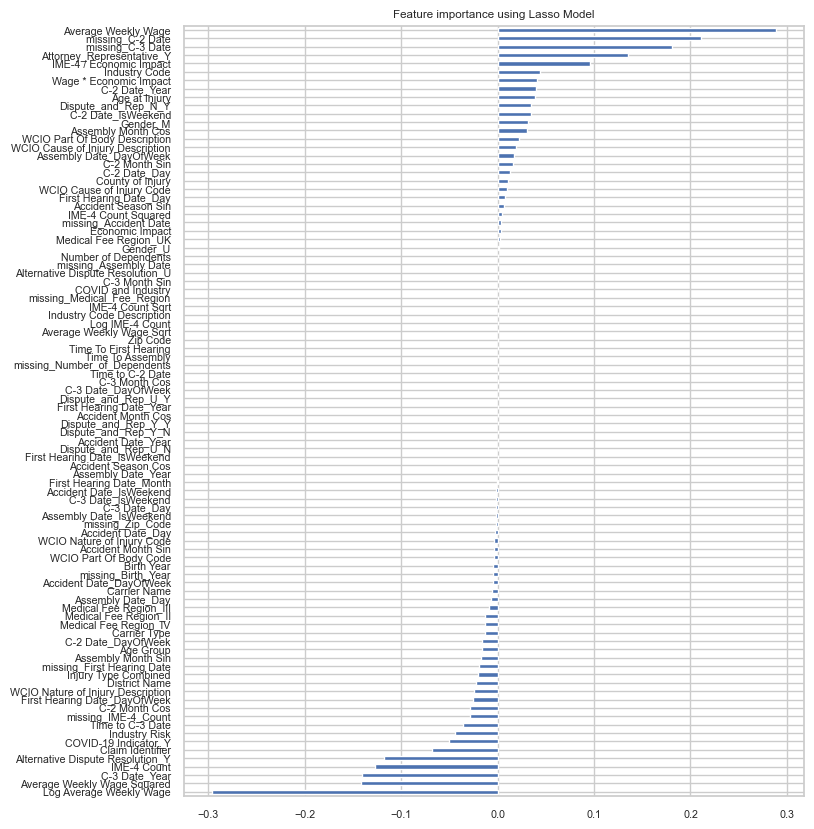

In [31]:
plot_importance(coef_modelLassoRegression,'Lasso')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Ridge Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Ridge Regression is a linear regression method that includes an L2 regularization term, which penalizes the sum of the squared coefficients. Unlike Lasso, Ridge does not eliminate features by setting coefficients to zero but instead reduces the magnitude of all coefficients, particularly for features with minor predictive power.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Ridge Regression is effective in handling multicollinearity and reducing model complexity without discarding features, making it ideal for datasets with many correlated variables.</li>
    <li><strong>How It Works:</strong> The L2 penalty shrinks all coefficients proportionally, stabilizing the model and preventing overfitting, especially when dealing with high-dimensional data.</li>
</ul>


In [32]:
modelRidgeRegressionCV = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
modelRidgeRegressionCV.fit(X_train_scaled, y_train_sampled)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=5)

In [33]:
best_alpha = modelRidgeRegressionCV.alpha_

In [34]:
modelRidgeRegression = Ridge(alpha=best_alpha)
modelRidgeRegression.fit(X_train_scaled, y_train_sampled)

Ridge()

In [35]:
# Print the number of coefficients
print(f"Number of coefficients: {len(modelRidgeRegression.coef_)}")

# Optionally, print the coefficients to check
print("Coefficients:", modelRidgeRegression.coef_)

Number of coefficients: 1
Coefficients: [[ 0.04896713  0.12342714 -0.00727991 -0.009125   -0.01492138 -0.54122352
   0.01575687 -0.02156675 -0.28581868  0.0497953   0.00490727  0.01018018
   0.0186773  -0.00458553 -0.0243461  -0.00756936  0.02175445  0.1082716
   0.00121503  0.00884196  0.          0.21165327  0.22760411 -0.03369777
  -0.03698388  0.         -0.11037848  0.         -0.00618453  0.93733796
  -0.88929819  0.02318095 -0.26550839 -0.02733936 -0.04433237 -0.00508231
  -0.54613383 -0.14502992  0.37894808 -0.02167165  0.05919717  0.14041577
   0.05981139  0.06991271 -0.01205022 -0.02160654  0.         -0.05964752
   0.08544569 -0.05514542  0.03236913  0.00339316 -0.01774269 -0.01359448
  -0.02694143  0.00178124  0.08698815  0.          0.         -0.05539261
  -0.02219534  0.0945445  -0.00284106 -0.00662891 -0.00145039 -0.02351158
  -0.01372261  0.02320879 -0.00392313  0.02654283  0.01916627 -0.02251547
   0.03935831 -0.02803672 -0.00572077 -0.00112142 -0.00208211  0.50623904

In [36]:
coef_modelRidgeRegression = pd.Series(modelRidgeRegression.coef_[0], index=X_train_scaled.columns)
print("Ridge picked " + str(sum(coef_modelRidgeRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelRidgeRegression == 0)) + " variables")

Ridge picked 85 variables and eliminated the other 7 variables


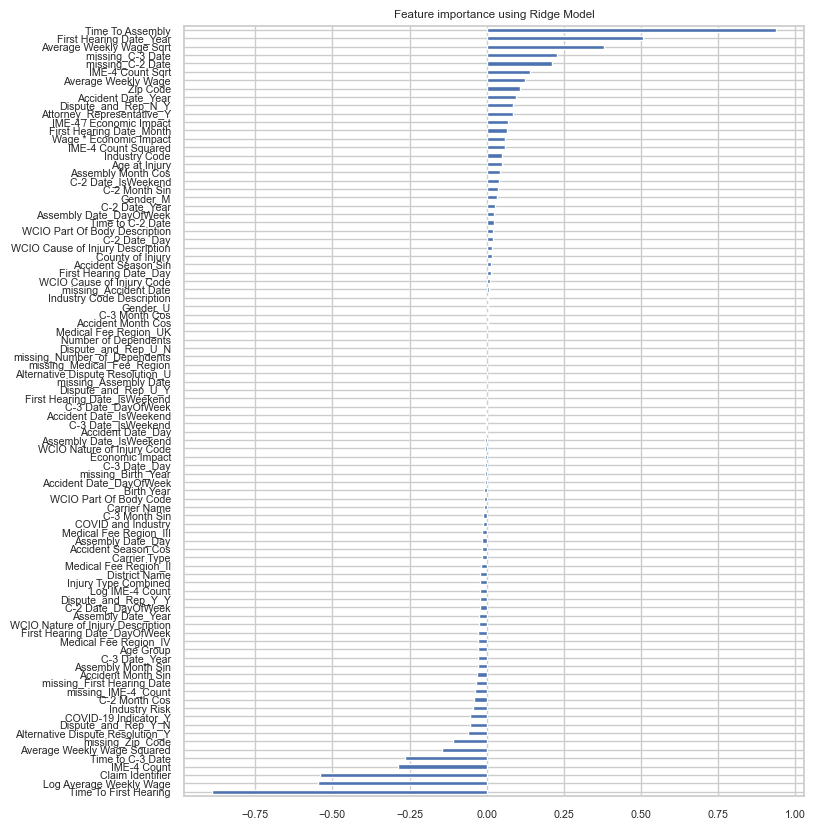

In [37]:
plot_importance(coef_modelRidgeRegression, 'Ridge')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Elastic Net
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Elastic Net is a regression technique that combines both L1 (Lasso) and L2 (Ridge) regularization penalties. It is particularly useful for datasets with highly correlated features, where it balances feature selection and coefficient shrinkage, preventing some limitations associated with Lasso and Ridge alone.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Elastic Net is effective in high-dimensional data where features are highly correlated, as it combines the strengths of Lasso and Ridge to improve feature selection and model stability.</li>
    <li><strong>How It Works:</strong> Elastic Net applies a weighted sum of the L1 and L2 penalties, allowing both feature elimination (Lasso effect) and coefficient shrinkage (Ridge effect) to enhance model accuracy and interpretability.</li>
</ul>


In [38]:
modelElasticNetCv = ElasticNetCV(cv=5, random_state=42)
modelElasticNetCv.fit(X_train_scaled, y_train_sampled)

ElasticNetCV(cv=5, random_state=42)

In [39]:
best_alpha = modelElasticNetCv.alpha_
best_l1_ratio = modelElasticNetCv.l1_ratio_

In [40]:
modelElasticNet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
modelElasticNet.fit(X_train_scaled, y_train_sampled)

ElasticNet(alpha=0.0017732615993127177, random_state=42)

In [41]:
coef_modelElasticNet = pd.Series(modelElasticNet.coef_, index = X_train_scaled.columns)
print("Elastic Net picked " + str(sum(coef_modelElasticNet != 0)) + " variables and eliminated the other " +  str(sum(coef_modelElasticNet == 0)) + " variables")

Elastic Net picked 68 variables and eliminated the other 24 variables


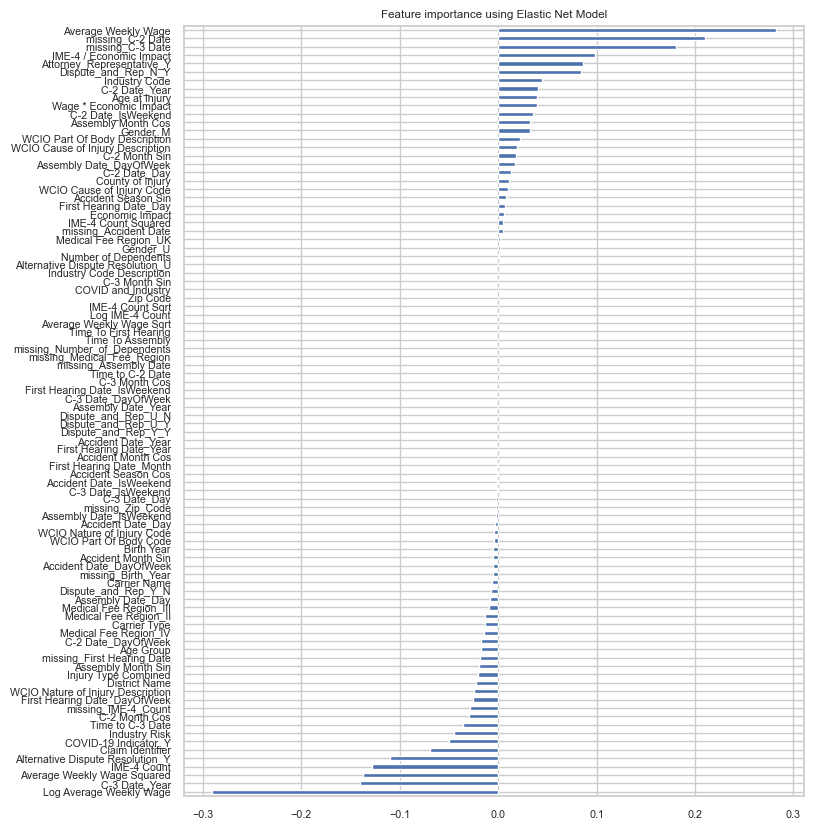

In [42]:
plot_importance(coef_modelElasticNet, 'Elastic Net')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Final Variables Selected by Feature Selection
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    After applying various feature selection methods, the following variables were retained as the most relevant for predicting the target outcome. These features demonstrated significant predictive power, contributing meaningfully to model accuracy and interpretability, while minimizing model complexity.
</p>


In [43]:
def mark_highly_correlated_features(data, isPearson, correlation_threshold = 0.8):

    if isPearson:
        corr_matrix = data.corr(method='pearson')
    else:
        corr_matrix = data.corr(method='spearman')

    correlation_decisions = {feature : 'keep' for feature in data.columns}

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation_value = corr_matrix.iloc[i, j]

            if abs(correlation_value) >= correlation_threshold:
                if correlation_decisions[feature1] == 'keep' and correlation_decisions[feature2] == 'keep':
                    if data[feature1].var() >= data[feature2].var():
                        correlation_decisions[feature2] = 'drop'
                    else:
                        correlation_decisions[feature1] = 'drop'

    return correlation_decisions

In [44]:
all_features = X_train_scaled.columns

In [45]:
# Create the base dictionary with feature names
data_columns = { 'Feature': all_features }

# Perform correlation-based feature selection using Pearson and Spearman
correlation_decisions_pearson = mark_highly_correlated_features(X_train_scaled, True)
correlation_decisions_spearman = mark_highly_correlated_features(X_train_scaled, False)

# Apply univariate feature selection based on variance (keeping non-zero variance features)
data_columns['Univariate'] = ['keep' if val != 0 else 'drop' for val in X_train_scaled.var()]

# Map correlation decisions for Pearson and Spearman
data_columns['Correlation(Pearson)'] = list(correlation_decisions_pearson.values())
data_columns['Correlation(Spearman)'] = list(correlation_decisions_spearman.values())

# Create the DataFrame with the feature decisions
df_data_columns_FM = pd.DataFrame(data_columns)
df_data_columns_FM.reset_index(drop=True, inplace=True)


In [46]:
def select_best_threshold_and_features(X_train_scaled, y_train, df_lasso, df_RidgeRegression, df_elasticnet, all_features, thresholds=[0.01, 0.05, 0.1, 0.2, 0.3]):
    # Initialize variables to store the best results
    best_threshold = None
    best_score = -float('inf')  # Start with a very low score
    best_selected_features = None

    # Initialize DataFrame to store feature decisions
    data_columns_EM = {'Feature': all_features}

    # Check input DataFrames for required columns
    for df, col in zip([df_lasso, df_RidgeRegression, df_elasticnet],
                       ['Lasso Coefficient', 'Ridge Coefficient', 'ElasticNet Coefficient']):
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}' in one of the DataFrames.")

    # Iterate through the given threshold values
    for threshold in thresholds:
        # Apply threshold to coefficients for each model
        data_columns_EM['Lasso Coefficient'] = ['keep' if x != 0 else 'drop' for x in df_lasso['Lasso Coefficient']]
        data_columns_EM['Ridge Coefficient'] = ['keep' if abs(x) > threshold else 'drop' for x in df_RidgeRegression['Ridge Coefficient']]
        data_columns_EM['ElasticNet Coefficient'] = ['keep' if abs(x) > threshold else 'drop' for x in df_elasticnet['ElasticNet Coefficient']]

        # Create a DataFrame to evaluate the decisions
        df_data_columns_EM = pd.DataFrame(data_columns_EM)

        # Select features that are kept by all three models (Lasso, Ridge, ElasticNet)
        selected_features_lasso = df_data_columns_EM[df_data_columns_EM['Lasso Coefficient'] == 'keep']['Feature'].values
        selected_features_ridge = df_data_columns_EM[df_data_columns_EM['Ridge Coefficient'] == 'keep']['Feature'].values
        selected_features_elasticnet = df_data_columns_EM[df_data_columns_EM['ElasticNet Coefficient'] == 'keep']['Feature'].values

        # Combine selected features for all models
        selected_features_combined = list(set(selected_features_lasso) & set(selected_features_ridge) & set(selected_features_elasticnet))

        if not selected_features_combined:
            print(f"No features selected for threshold {threshold}. Skipping.")
            continue

        # Filter the training data to keep only the selected features
        X_train_selected = X_train_scaled[selected_features_combined]

        if X_train_selected.shape[0] != len(y_train):
            raise ValueError(f"Shape mismatch: X_train_selected has {X_train_selected.shape[0]} rows, "
                             f"but y_train has {len(y_train)} rows.")

        # Evaluate the model performance with cross-validation (using R2 score as an example)
        score = cross_val_score(LassoCV(cv=5), X_train_selected, y_train, cv=5, scoring='r2').mean()

        # Debugging output
        print(f"Threshold: {threshold}, Score: {score}, Features: {len(selected_features_combined)}")

        # If the score for this threshold is better, update the best threshold and selected features
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_selected_features = selected_features_combined

    # Return the best threshold, the best features selected, and the best score
    return best_threshold, best_selected_features, best_score, df_data_columns_EM


In [47]:
df_lasso = pd.DataFrame({'Feature': all_features, 'Lasso Coefficient': coef_modelLassoRegression})
df_RidgeRegression = pd.DataFrame({'Feature': all_features, 'Ridge Coefficient': coef_modelRidgeRegression})
df_elasticnet = pd.DataFrame({'Feature': all_features, 'ElasticNet Coefficient': coef_modelElasticNet})

best_threshold, best_selected_features, best_score, df_data_columns_EM = select_best_threshold_and_features(X_train_scaled, y_train_sampled, df_lasso, df_RidgeRegression, df_elasticnet, all_features)

Threshold: 0.01, Score: 0.12161860081674733, Features: 41
Threshold: 0.05, Score: 0.10824455895264888, Features: 12
Threshold: 0.1, Score: 0.07342459946568183, Features: 6
Threshold: 0.2, Score: 0.04590926912731572, Features: 2
No features selected for threshold 0.3. Skipping.


In [48]:
# Extract the selected features from the results
best_features_results = pd.read_csv("../results/best_features_results.csv")
all_best_features = best_features_results["Selected_features"].str.split(", ").explode().unique()

# Initialize the data dictionary
data_columns_WM = {"Feature": all_features}

# Iterate through each model to assign "keep" or "drop" decisions based on feature selection
for model in best_features_results["Model"].unique():
    model_data = best_features_results[best_features_results["Model"] == model]
    
    # Ensure the decision list has the same length as all_features
    features_decision = [
        feature if feature in model_data["Selected_features"].values[0] else 'drop'
        for feature in all_features
    ]
    
    # Assign the decisions for the current model
    data_columns_WM[f"{model} Decision"] = features_decision

# Create the final DataFrame with feature selection decisions
df_data_columns_WM = pd.DataFrame(data_columns_WM)


In [49]:
# Create the final DataFrame with feature names
df_final_decision = pd.DataFrame({'Feature': all_features})

# Apply the analyze_feature_consensus function for different methods
df_final_decision['Filter Methods Decision'] = analyze_feature_consensus(df_data_columns_FM, minimum_keep=2)['Final_Decision']
df_final_decision['Embedded Methods Decision'] = analyze_feature_consensus(df_data_columns_EM, minimum_keep=1)['Final_Decision']
df_final_decision['Wrapper Methods Decision'] = analyze_feature_consensus(df_data_columns_WM, minimum_keep=4)['Final_Decision']

# Display the final DataFrame
df_final_decision


Feature Filter Methods Decision Embedded Methods Decision  \
0         Age at Injury                    keep                      keep   
1   Average Weekly Wage                    keep                      keep   
2            Birth Year                    keep                      keep   
3          Carrier Name                    keep                      keep   
4          Carrier Type                    keep                      keep   
..                  ...                     ...                       ...   
87   Assembly Month Cos                    drop                      keep   
88        C-2 Month Sin                    keep                      keep   
89        C-2 Month Cos                    keep                      keep   
90        C-3 Month Sin                    keep                      drop   
91        C-3 Month Cos                    keep                      drop   

   Wrapper Methods Decision  
0                      drop  
1                      drop  
2                      drop  
3                      drop  
4                      drop  
..                      ...  
87                     drop  
88                     drop  
89                     drop  
90                     drop  
91                     drop  

[92 rows x 4 columns]

In [50]:
def select_features(df):
    selected_features = [
        row['Feature'] for _, row in df.iterrows() if [row['Filter Methods Decision'], row['Embedded Methods Decision'], row['Wrapper Methods Decision']].count('keep') >= 2
    ]
    dropped_features = [
        row['Feature'] for _, row in df.iterrows() if [row['Filter Methods Decision'], row['Embedded Methods Decision'], row['Wrapper Methods Decision']].count('keep') < 2
    ]

    return selected_features, dropped_features


In [51]:
# Call select_features function
final_features, dropped_features = select_features(df_final_decision)

# Print the results directly
print("Features selecionadas:", final_features)
print("Features descartadas:", dropped_features)


Features selecionadas: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury', 'District Name', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Number of Dependents', 'missing_Accident Date', 'missing_C-2 Date', 'missing_First Hearing Date', 'missing_IME-4_Count', 'missing_Zip_Code', 'missing_Birth_Year', 'Time To Assembly', 'Time To First Hearing', 'Time to C-3 Date', 'Age Group', 'Industry Risk', 'Economic Impact', 'Average Weekly Wage Squared', 'IME-4 / Economic Impact', 'Injury Type Combined', 'Attorney_Representative_Y', 'COVID-19 Indicator_Y', 'Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Accident Date_Day', 'Accident Date_DayOfWeek', 'Accident Date_IsWeekend', 'Assembly Date_Da

In [61]:
dropped_features.remove("Claim Identifier")
X_train_cleaned = X_train.drop(columns=dropped_features)

# Step 3: Apply the same feature dropping to X_val and data_test
X_val_cleaned = X_val.drop(columns=dropped_features, errors='ignore')  # Ignore missing features in validation data
data_test_cleaned = data_test.drop(columns=dropped_features, errors='ignore')  # Ignore missing features in test data

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Correlation Analysis
</h2>
<hr style="border: 1px solid #4A90E2;">


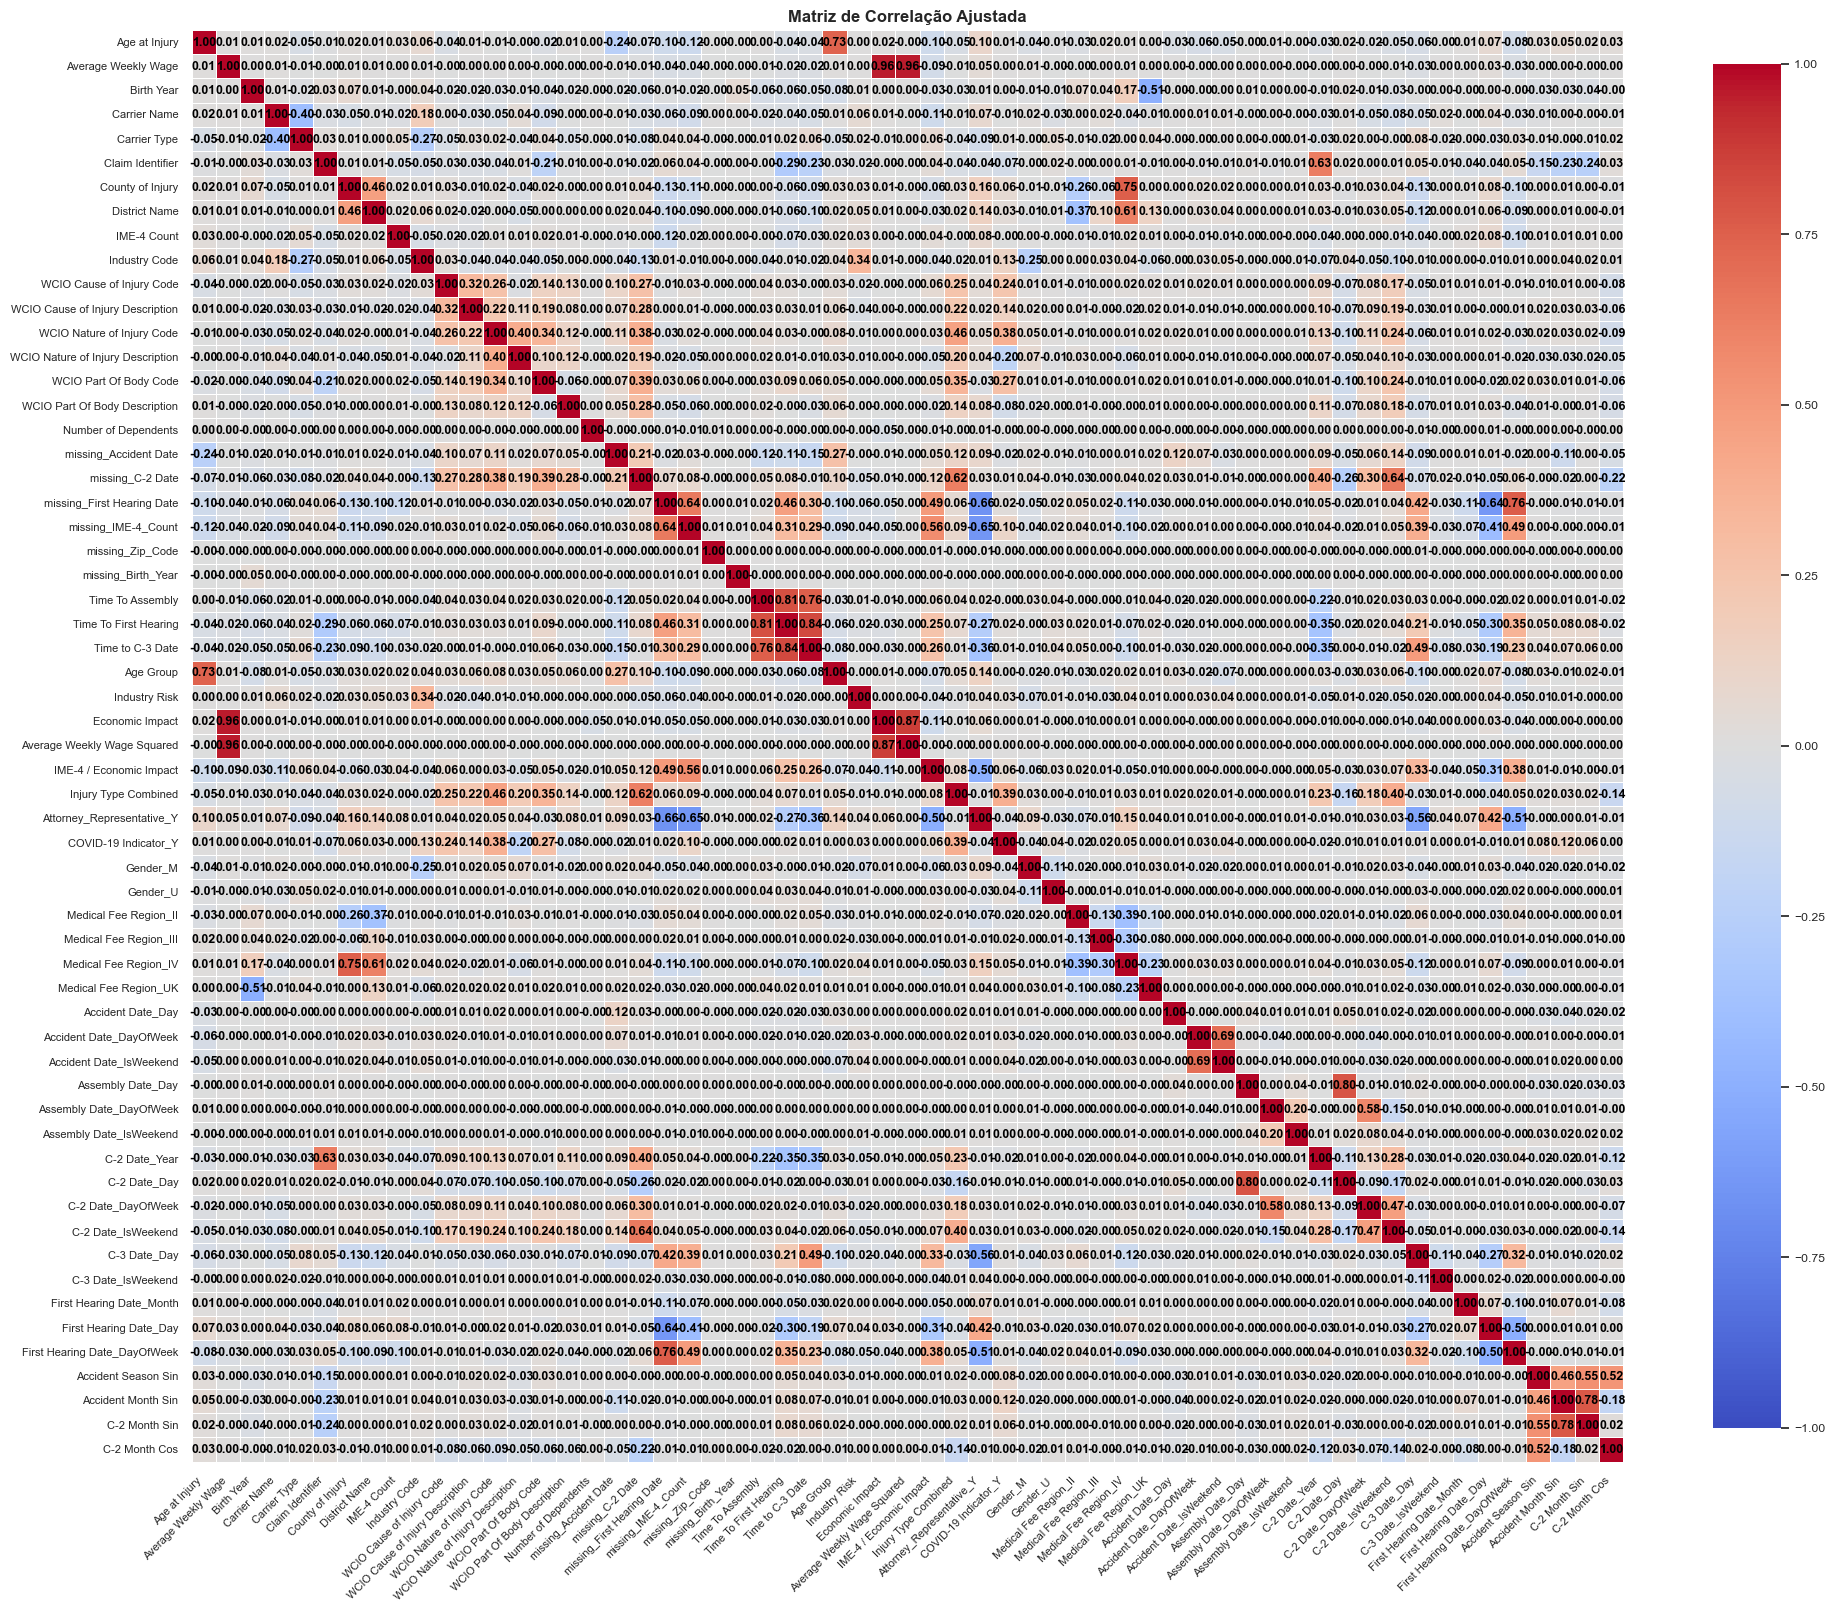

In [62]:
corr_matrix = X_train_cleaned.select_dtypes(include=['number']).corr()

sns.set(style='whitegrid', font_scale=0.8)

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 9, 'weight': 'bold', 'color': 'black'})

# Título e rótulos
plt.title('Matriz de Correlação Ajustada', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Download Dataset
</h2>
<hr style="border: 1px solid #4A90E2;">


In [63]:
X_train_cleaned.to_csv("../data/X_train_post_FS.csv", index=False)
X_train_ar.to_csv("../data/X_train_ar_post_FS.csv", index=False)
X_train_wcb.to_csv("../data/X_train_wcb_post_FS.csv", index=False)

In [64]:
y_train.to_csv("../data/y_train_post_FS.csv", index=False)
y_train_ar.to_csv("../data/y_train_ar_post_FS.csv", index=False)
y_train_wcb.to_csv("../data/y_train_wcb_post_FS.csv", index=False)

In [65]:
X_val_cleaned.to_csv("../data/X_val_post_FS.csv", index=False)
X_val_ar.to_csv("../data/X_val_ar_post_FS.csv", index=False)
X_val_wcb.to_csv("../data/X_val_wcb_post_FS.csv", index=False)

In [66]:
y_val.to_csv("../data/y_val_post_FS.csv", index=False)
y_val_ar.to_csv("../data/y_val_ar_post_FS.csv", index=False)
y_val_wcb.to_csv("../data/y_val_wcb_post_FS.csv", index=False)


In [67]:
data_test_cleaned.to_csv("../data/data_test_post_FS.csv", index=False)
data_test_ar.to_csv("../data/data_test_ar_post_FS.csv", index=False)
data_test_wcb.to_csv("../data/data_test_wcb_post_FS.csv", index=False)